In [38]:

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn2pmml import PMMLPipeline,sklearn2pmml

from xgboost import XGBClassifier
from xgboost import plot_importance

from tag_num import TagsNum
from plot_learning_curve import *
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [35]:
# 读取数据并定义X， y， 切分train，valid

train = pd.read_csv('qz_andr.csv')
taglist = pd.read_csv('个推编码字典.txt', header = None, sep = '|')
tag_dict = taglist.set_index([0]).to_dict()[1]

X = train['tags']
y = train['is_reg']

X_train, X_valid, y_train, y_valid = train_test_split(X,y,
                                                      stratify=y,
                                                      test_size = 0.3,
                                                     random_state = 123)
X.shape

y.value_counts(dropna=False)

1    23062
0     9490
Name: is_reg, dtype: int64

In [4]:
# 特征构造

combined_feature = FeatureUnion([('token', CountVectorizer()),
                                ('count', TagsNum())])

features_train = combined_feature.fit(X_train, y_train).transform(X_train)
features_valid = combined_feature.transform(X_valid)
features = combined_feature.transform(X)

In [6]:
# 训练模型并调参，手动

clf = XGBClassifier(max_depth=2,
                    eval_metric='auc',
                    learning_rate = 0.1,
                    n_estimators= 10,
                    subsample= 0.5,
                    n_jobs = 8,
                    colsample_bylevel = 0.7,
#                     reg_alpha=3,
                    radom_state = 123,
                    )

eval_set = [(features_train, y_train), (features_valid, y_valid)]
clf.fit(features_train, y_train, eval_metric='auc', eval_set=eval_set, verbose=True,early_stopping_rounds=10)

[0]	validation_0-auc:0.669205	validation_1-auc:0.665918
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.693576	validation_1-auc:0.690789
[2]	validation_0-auc:0.716544	validation_1-auc:0.716978
[3]	validation_0-auc:0.718088	validation_1-auc:0.718358
[4]	validation_0-auc:0.718214	validation_1-auc:0.718024
[5]	validation_0-auc:0.722429	validation_1-auc:0.723615
[6]	validation_0-auc:0.722436	validation_1-auc:0.724051
[7]	validation_0-auc:0.725265	validation_1-auc:0.725134
[8]	validation_0-auc:0.730501	validation_1-auc:0.727222
[9]	validation_0-auc:0.729814	validation_1-auc:0.726436


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
       colsample_bytree=1, eval_metric='auc', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
       n_estimators=10, n_jobs=8, nthread=None,
       objective='binary:logistic', radom_state=123, random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5)

In [39]:
# feature importance

features_importance = pd.DataFrame({
    "feature_name": [tag_dict[feature.split('__')[1]] if feature.split('__')[1] in tag_dict else feature.split('__')[1] for feature in combined_feature.get_feature_names()],
    "importance": clf.feature_importances_
})

features_importance.sort_values(by = "importance", ascending = False)[:10]
features_importance.sort_values(by = "importance")[:10]

,feature_name,importance
220,网贷,0.300000
42,性别女,0.133333
318,购物,0.100000
323,网购,0.100000
203,金融理财,0.100000
384,tags_num,0.033333
269,代驾,0.033333
270,代驾_活跃低,0.033333
157,社区,0.033333
39,已婚,0.033333


,feature_name,importance
0,02a300,0.0
259,二手车_活跃高,0.0
258,二手车_活跃低,0.0
257,二手车,0.0
256,驾考_活跃中,0.0
255,驾考_活跃高,0.0
254,驾考_活跃低,0.0
253,驾考,0.0
252,汽车,0.0
251,休闲旅行_活跃中,0.0


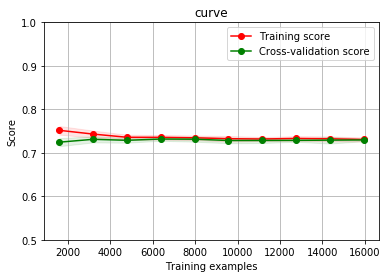

In [33]:
# 画学习曲线，cv。

cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.3, random_state = 123)
learning_curve = plot_learning_curve(clf, 'curve', 
                                     features_train, y_train,
                                     cv=cv,
                                     ylim = (0.5, 1),
                                     scoring = "roc_auc",
                                     train_sizes=np.linspace(.1, 1.0, 10))
learning_curve.show()

In [8]:
# 训练模型并调参，Gridsearch, 非常费时，慎重

# from sklearn.model_selection import GridSearchCV

# bst = XGBClassifier(n_jobs = 8, eval_metric = 'auc', random_state=123)
# params = {
#     'max_depth':[2,3,5],
#     'learning_rate':[0.01,0.05,0.1,0.5],
#     'n_estimators':[5,10,20,50],
#     'subsample':[0.3,0.5,0.7,0.9],
#     'colsample_bylevel':[0.3,0.5,0.7],
#     'reg_alpha':[0,1],
# }

# clf_search = GridSearchCV(bst,params).fit(X, y)

In [9]:
# clf_search.best_estimator_

### clf_search.best_estimator_
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,  
       colsample_bytree=0.5, eval_metric='auc', gamma=0, learning_rate=0.5,  
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,  
       n_estimators=50, n_jobs=8, nthread=None,  
       objective='binary:logistic', random_state=123, reg_alpha=3,  
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,  
       subsample=0.7)  

In [12]:
# 用gridsearch params

clf_auto = XGBClassifier(max_depth=3,
                    eval_metric='auc',
                    learning_rate = 0.5,
                    n_estimators= 50,
                    subsample= 0.7,
                    n_jobs = 8,
                    colsample_bylevel = 0.5,
                    reg_alpha=3,
                    random_state = 123,
                    )
clf_auto.fit(features_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
       colsample_bytree=1, eval_metric='auc', gamma=0, learning_rate=0.5,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=50, n_jobs=8, nthread=None,
       objective='binary:logistic', random_state=123, reg_alpha=3,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.7)

In [40]:
# feature importance

features_importance = pd.DataFrame({
    "feature_name": [tag_dict[feature.split('__')[1]] if feature.split('__')[1] in tag_dict else feature.split('__')[1] for feature in combined_feature.get_feature_names()],
    "importance": clf_auto.feature_importances_
})

features_importance.sort_values(by = "importance", ascending = False)[:10]
features_importance.sort_values(by = "importance")[:10]

,feature_name,importance
384,tags_num,0.055556
220,网贷,0.023392
366,搞笑,0.020468
58,0utw00,0.020468
86,打车出行,0.020468
157,社区,0.017544
196,外卖,0.017544
216,信用卡,0.017544
224,投资理财,0.014620
159,社区_活跃高,0.014620


,feature_name,importance
192,洗衣,0.0
191,找阿姨,0.0
383,减肥_活跃中,0.0
193,洗衣_活跃低,0.0
194,洗衣_活跃高,0.0
195,洗衣_活跃中,0.0
355,听书_活跃中,0.0
198,外卖_活跃高,0.0
200,做饭,0.0
201,做饭_活跃高,0.0


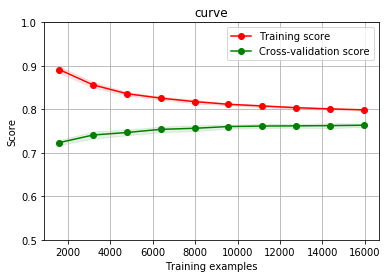

In [29]:
# 画学习曲线，cv

cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.3, random_state = 0)
learning_curve = plot_learning_curve(clf_auto, 'curve', 
                                     features_train, y_train,
                                     cv=cv,
                                     ylim = (0.5,1),
                                     scoring = "roc_auc",
                                     train_sizes=np.linspace(.1, 1.0, 10))
learning_curve.show()

In [15]:
# 写成pipeline，refit X, y, 并生成pmml文件

pipeline = PMMLPipeline([
    ('feature_engineer', combined_feature),
    ('clf', clf)
])

pipeline.fit(X, y)
# sklearn2pmml(pipeline, 'QzAndorid_GeTui_svm.pmml', debug= True)


pipeline_auto = PMMLPipeline([
    ('feature_engineer', combined_feature),
    ('clf', clf_auto)
])

pipeline_auto.fit(X, y)
# sklearn2pmml(pipeline, 'QzAndorid_GeTui_svm.pmml', debug= True)

PMMLPipeline(steps=[('feature_engineer', FeatureUnion(n_jobs=1,
       transformer_list=[('token', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('count', TagsNum())],
       transformer_weights=None)),
       ('clf', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
       colsample_bytree=1, eval_metric='auc', gamma=0, learning_rate=0.5,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=50, n_jobs=8, nthread=None,
       objective='binary:logistic', random_state=123, reg_alpha=3,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.7))])

In [30]:
# 猎豹平台数据测试

test = pd.read_csv('liebao_loan.csv')

test_X_1 = test['tags']
test_y_1 = test['y_1']

test_X_2 = test['tags']
test_y_2 = test['y_2']

test_X_3 = test['tags'][test['y_1'] == 1]
test_y_3 = test['y_2'][test['y_1'] == 1]

In [31]:
# 用pipeline预测

test_y_pred_1 = pipeline.predict_proba(test_X_1)[:,1]
test_y_pred_2 = pipeline.predict_proba(test_X_2)[:,1]
test_y_pred_3 = pipeline.predict_proba(test_X_3)[:,1]


roc_auc_score(test_y_1, test_y_pred_1), roc_auc_score(test_y_2, test_y_pred_2),roc_auc_score(test_y_3, test_y_pred_3)

(0.50051843468676593, 0.5846945089349459, 0.58730669965659188)

In [34]:
# 用pipeline_auto预测

test_y_pred_1 = pipeline_auto.predict_proba(test_X_1)[:,1]
test_y_pred_2 = pipeline_auto.predict_proba(test_X_2)[:,1]
test_y_pred_3 = pipeline_auto.predict_proba(test_X_3)[:,1]


roc_auc_score(test_y_1, test_y_pred_1), roc_auc_score(test_y_2, test_y_pred_2),roc_auc_score(test_y_3, test_y_pred_3)

(0.49636270764182683, 0.57854396606888825, 0.58404325661753731)